# Bayesian tracking system optimisation

This notebook will optimise a simple tracking system using Bayesian optimization with Gaussian processes. This was completed as part of the Addressing Hadron Collider Challenges with Machine Learning course of the Advanced Machine Learning specialisation on Coursera.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils

## Geometry generation

This simple tracking system consists of 4 layers of straw tubes, which detects particles that fly through them. Each layer has 200 tubes. The system is parameterised by six adjustable parameters: $y_{1}$, $y_{2}$, $y_{3}$, $z_{1}$, $z_{2}$, $z_{3}$. These parameters describe shifts between the layers as shown in the following figure: 

<img src="https://github.com/hse-aml/hadron-collider-machine-learning/blob/master/week5/pic/system.png?raw=1" alt="Drawing" style="width: 700px;">

For the purposes of this notebook, the radius $R$ of tubes is 1 cm and the distance between tubes in one layer (pitch) is 4 cm. These values are taken to be constants and will not be changed. Also, z-value must be more than 2, otherwise these tubes will intersect.

For example:

In [2]:
#constant parameters
R = 1. # cm
pitch = 4.0 #cm 

#adjustable parameters
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

Using these parameter values, $Z$ and $Y$ coordinates of tubes in the tracking system are generated.

In [3]:
tr = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()

Several tubes of the generated geometry can now be visualised.

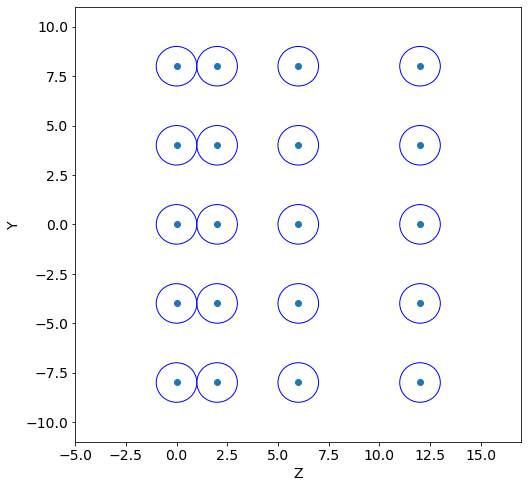

In [4]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

## Tracks generation

Several tracks of particles that fly in the tracking system will now be generated. Straight tracks will be considered with the equation: 

$$
y = kz + b
$$

where $z, y$ are coordinates of the track, $k$ is slope of the track and $b$ is the y intercept.

Track parameters are generated from the following distributions:

$$
b \in U(b_{min}, b_{max})\\
k = tan(\alpha), \alpha \in N(\mu_{\alpha}, \sigma_{\alpha})
$$

where $U$ is uniform distribution and $N$ is normal distribution.

In [5]:
N_tracks = 1000
t = utils.Tracks(b_min=-100, b_max=100, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

The tubes geometry with the generated tracks can be visualised.

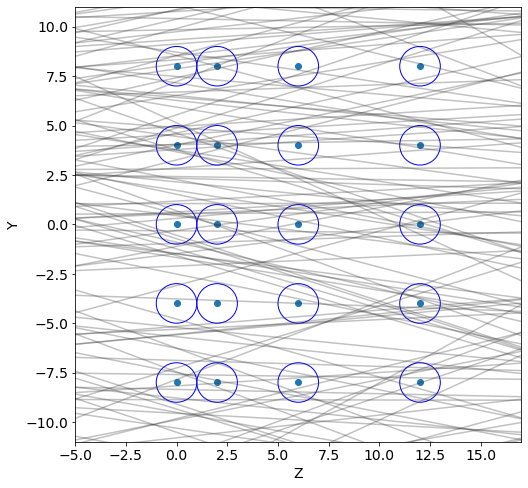

In [6]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

## Target metric

For a given geaometry of the tracking system, the ratio of tracks with at least 2 hits to the total number of tracks will now be calculated:

$$Score = \frac{N\_tracks_{n\_hits \ge 2}}{N\_tracks}$$

The higher the score, the better.

In [7]:
score = utils.get_score(Z, Y, tracks, R)
print(score)

0.648


## Optimization

The parameters of geometry of the tracking system that provides the highest **score** value need to be found. To achieve this, a minimisation problem willbe solved - the goal is to minimise the **1-score** value, which is an objective function of the optimisation

Below, the ranges of the adjustable parameters of the system are defined.

In [8]:
# You can change these values
y1_min, y1_max = [0, 4]
y2_min, y2_max = [0, 4]
y3_min, y3_max = [0, 4]
z1_min, z1_max = [2, 10]
z2_min, z2_max = [2, 10]
z3_min, z3_max = [2, 10]

Next, the tracks used during the optimisation are generated.

In [9]:
t = utils.Tracks(-100, 100, 0, 0.2)
tracks = t.generate(1000)

Now, the objective function of the optimisation is defined.

In [10]:
def objective(x):
    
    R, pitch, y1, y2, y3, z1, z2, z3 = x
    Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
    val = utils.get_score(Z, Y, tracks, R)
    
    return 1. - val #the smaller the better.

## Grid search

Firstly, grid search is used to try to solve the optimisation problem and find optimal parameters.

In [11]:
%%time

#number of unique values for each of the adjustable parameters
n_points = 2

#define grid of parameters
y1_grid = np.linspace(y1_min, y2_max, n_points)
y2_grid = np.linspace(y2_min, y2_max, n_points)
y3_grid = np.linspace(y3_min, y3_max, n_points)
z1_grid = np.linspace(z1_min, z1_max, n_points)
z2_grid = np.linspace(z2_min, z2_max, n_points)
z3_grid = np.linspace(z3_min, z3_max, n_points)

#define list to store optimisation results
min_objective_values = []
params_for_min_objective_values = []

is_first = True

#loop on grid
for y1 in y1_grid:
    for y2 in y2_grid:
        for y3 in y3_grid:
            for z1 in z1_grid:
                for z2 in z2_grid:
                    for z3 in z3_grid:

                        #calculate objective function value for a grid node
                        x = [R, pitch, y1, y2, y3, z1, z2, z3]
                        val = objective(x)

                        if is_first:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                            is_first = False
                        elif val < min_objective_values[-1]:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                        else:
                            min_objective_values.append(min_objective_values[-1])
                            params_for_min_objective_values.append(params_for_min_objective_values[-1])

CPU times: user 3.75 s, sys: 26.4 ms, total: 3.77 s
Wall time: 42.3 s


#### Plot the optimisation curve

Objective optimum =  0.244


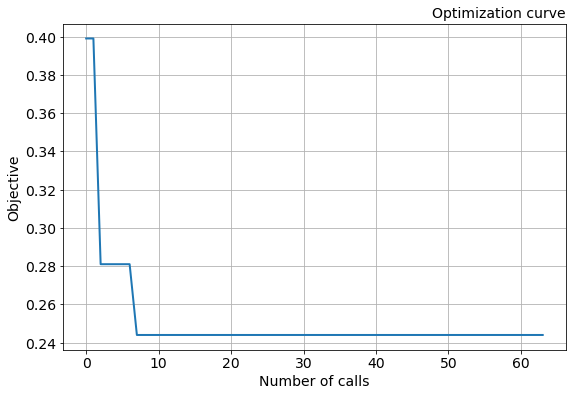

In [12]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [13]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  0.0
y2 =  0.0
y3 =  0.0
z1 =  10.0
z2 =  10.0
z3 =  10.0


#### Display the optimal tracking system geometry

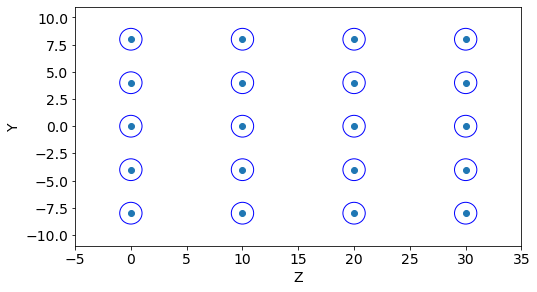

In [14]:
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

## Random search

Now, grid search is modified, where random points in the parameter space are generated instead of the grid to find the optimal parameters.

In [15]:
%%time

#number of random point to generate
n_points = 100

#define random values on tracking system parameters
y1_grid = np.random.RandomState(12).uniform(y1_min, y1_max, n_points)
y2_grid = np.random.RandomState(13).uniform(y2_min, y2_max, n_points)
y3_grid = np.random.RandomState(14).uniform(y3_min, y3_max, n_points)
z1_grid = np.random.RandomState(15).uniform(z1_min, z1_max, n_points)
z2_grid = np.random.RandomState(16).uniform(z2_min, z2_max, n_points)
z3_grid = np.random.RandomState(17).uniform(z3_min, z3_max, n_points)

#define list to store optimisation results
min_objective_values = []
params_for_min_objective_values = []

for i in range(n_points):
    
    y1 = y1_grid[i]
    y2 = y2_grid[i]
    y3 = y3_grid[i]
    z1 = z1_grid[i]
    z2 = z2_grid[i]
    z3 = z3_grid[i]
    
    #calculate objective function value for a grid node
    x = [R, pitch, y1, y2, y3, z1, z2, z3]
    val = objective(x)
    
    if i==0:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    elif val < min_objective_values[-1]:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    else:
        min_objective_values.append(min_objective_values[-1])
        params_for_min_objective_values.append(params_for_min_objective_values[-1])

CPU times: user 5.85 s, sys: 39.6 ms, total: 5.88 s
Wall time: 1min 6s


#### Plot the optimisation curve

Objective optimum =  0.18400000000000005


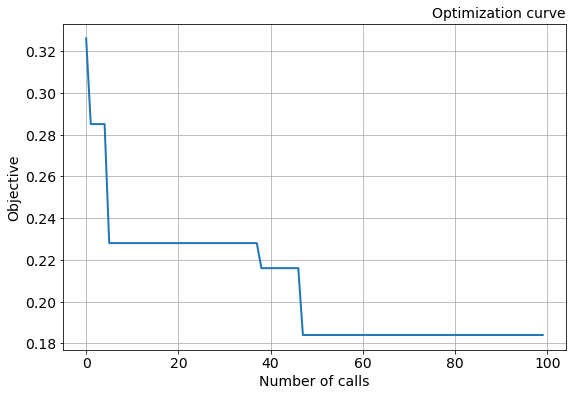

In [16]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [17]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  1.4948925952956613
y2 =  2.418155314526844
y3 =  1.8471834856632237
z1 =  2.246045068366281
z2 =  4.171926186309445
z3 =  3.0715653406063437


#### Display the optimal tracking system geometry

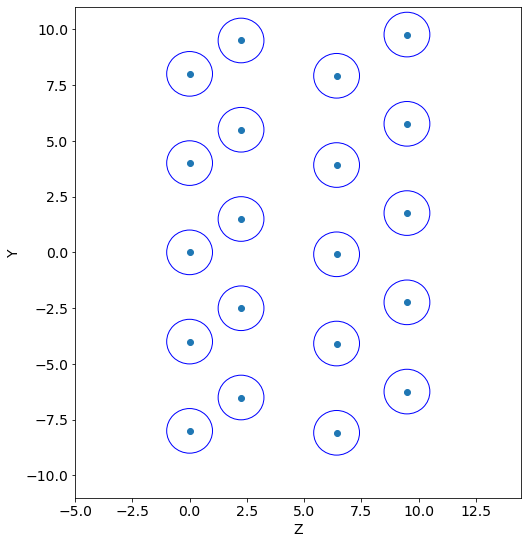

In [18]:
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

## Bayesian optimisation with Gaussian processes

Now, Bayesian optimisation will be implemented using [scikit-optimize](http://scikit-optimize.github.io/) library to find optimal tracking system geometry. During the optimisation, Lower Confidence Bound (LCB) acquisition function is used:

$$
LCB(x) = \mu(x) - \kappa(x) 
$$

where $\kappa$ is an adjustable parameter that defines the exploration-exploitation trade-off of the optimization.

In [21]:
from skopt import gp_minimize

y1_min, y1_max = [-10, 20]
y2_min, y2_max = [-10, 20]
y3_min, y3_max = [-10, 20]
z1_min, z1_max = [2, 15]
z2_min, z2_max = [2, 15]
z3_min, z3_max = [2, 15]

kappa= 30.1
dimentions = [(R, R + 10**-6), (pitch, pitch + 10**-6), 
              (y1_min, y1_max), (y2_min, y2_max), (y3_min, y3_max),
              (z1_min, z1_max), (z2_min, z2_max), (z3_min, z3_max)]

res = gp_minimize(func=objective,                   #function to minimise
                  dimensions=dimentions,            #bounds on each dimension of x
                  acq_func="LCB",                   #acquisition function
                  n_calls=120,                      #number of evaluations of f 
                  n_random_starts=50,               #number of random initialisation points
                  noise=0.01**2,                    #noise level (optional)
                  random_state=123,                 #random seed
                  kappa=kappa,                      #adjustable parameter of LCB
                  n_jobs=5)

#### Plot the optimisation curve

Objective optimum =  0.10399999999999998


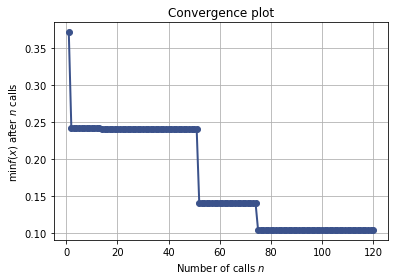

In [22]:
from skopt.plots import plot_convergence
print("Objective optimum = ", res.fun)
plot_convergence(res)

#### Display the optimal tracking system geometry

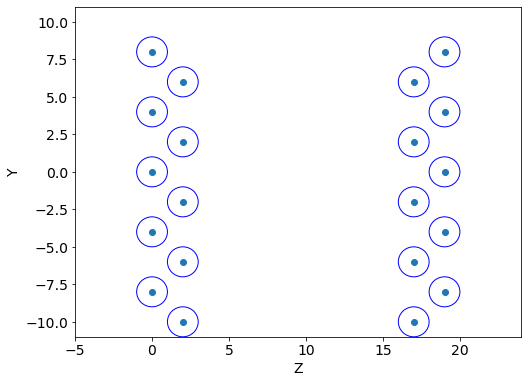

In [23]:
[R, pitch, y1, y2, y3, z1, z2, z3] = res.x

#plot the geometry
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)